In [1]:
# Hypothesis: smaller kernel sizes will lead to higher accuracies of classification in fined-tuned image classification
# We think this is likely due to the ability of the CNN to detect smaller features between relatively similar images of the same species
# Independent Variables: kernel size
# Constant Variables: number of layers, types of layers, input shape, epoches, hyperparamaters(depth,padding)
# Dependent Variables: Accuracy
# Limitations: we are foregoing pure accuracy for experimental reasons - we could get higher accuracy if we tried but we're keeping
# things constant for consistancy between models
# Currently only using Input, Convolutional, Relu, Pool, and FC/Dense layers. Can add Dense and Dropout if we have time
# Reference to www.cs231n.github.io/convolutional-networks

In [2]:
# 3. Import libraries and modules
import os, cv2, argparse
import numpy as np
import pandas as pd
import matplotlib.pylab as plt
from matplotlib import pyplot
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential, load_model
from keras.layers import Dense, Dropout, Activation, Flatten, Conv2D, MaxPooling2D
from keras.utils import np_utils
from numpy.random import RandomState
np.random.seed(123)  # for reproducibility
import sys
import random

/home/cfu288/.local/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [3]:
def shuffle_data(arr1, arr2):
    seed = random.randint(0, 1000)
    ran = RandomState(seed)
    ran.shuffle(arr1)
    ran = RandomState(seed)
    ran.shuffle(arr2)

In [4]:
# INPUT
TRAIN_DIR = './training/'
TEST_DIR = './validation/'
EPOCHS = 10

In [5]:
# Setup, Read in images, Preprocess images for training
TRAIN_IMG, TRAIN_CLS, TEST_IMG, TEST_CLS = ([] for i in range(4))
COLS = ['Label', 'Latin Name', 'Common Name', 'Train Images', 'Validation Images']
LABELS = pd.read_csv('./monkey_labels.txt', names=COLS, skiprows=1)
CLASSES = [x for x in range(0, len(LABELS))]

# read in all images
# resizing the images to 100x100 to make training faster
print("READING IN AND FORMATTING IMAGES")
for x in range(0, len(LABELS)):
    train_dir = TRAIN_DIR + LABELS.loc[x,'Label'].strip() + '/'
    test_dir = TEST_DIR + LABELS.loc[x,'Label'].strip() + '/'
    for file in os.listdir(train_dir):
        if not file.endswith('jpg'):
            print("empty file")
            continue
        img = cv2.imread(train_dir + file)
        if img is not None:
            img = cv2.resize(img, (100, 100))
            TRAIN_IMG.append(img)
            TRAIN_CLS.append(x)
    for file in os.listdir(test_dir):
        img = cv2.imread(test_dir + file)
        if img is not None:
            img = cv2.resize(img, (100, 100))
            TEST_IMG.append(img)
            TEST_CLS.append(x)
print("COMPLETE")

READING IN AND FORMATTING IMAGES
empty file
COMPLETE


In [6]:
# convert to numpy arrays
TRAIN_IMG = np.array(TRAIN_IMG)
TEST_IMG = np.array(TEST_IMG)
TRAIN_CLS = np.array(TRAIN_CLS)
TEST_CLS = np.array(TEST_CLS)

# Preprocess images
# Reshape them to theanos format (channels, hight, width) # changed to tensorflow
# Convert to 0-255 to value in [0-1]
# TRAIN_IMG = TRAIN_IMG.reshape(TRAIN_IMG.shape[0], 3, 100, 100)
# TEST_IMG = TEST_IMG.reshape(TEST_IMG.shape[0], 3, 100, 100)
TRAIN_IMG = TRAIN_IMG.astype('float32')
TEST_IMG = TEST_IMG.astype('float32')
TRAIN_IMG /= 255
TEST_IMG /= 255

# Reshape class labels
TRAIN_CLS = np_utils.to_categorical(TRAIN_CLS, 10)
TEST_CLS = np_utils.to_categorical(TEST_CLS, 10)

# Shuffle the data
shuffle_data(TRAIN_IMG, TRAIN_CLS)
shuffle_data(TEST_IMG, TEST_CLS)

In [7]:
#Inc training data through image aug
shift = 0.2
#datagen = ImageDataGenerator()
# datagen = ImageDataGenerator(rotation_range=90)
# #datagen = ImageDataGenerator(width_shift_range=shift, height_shift_range=shift)
# #datagen = ImageDataGenerator(featurewise_center=True, featurewise_std_normalization=True)
# # fit parameters from data
# datagen.fit(TRAIN_IMG)
# # https://machinelearningmastery.com/image-augmentation-deep-learning-keras/

# for X_batch, y_batch in datagen.flow(TRAIN_IMG, TRAIN_CLS, batch_size=9):
#     # create a grid of 3x3 images
#     for i in range(0, 9):
#         pyplot.subplot(330 + 1 + i)
#         pyplot.imshow(X_batch[i].reshape(100, 100, 3), cmap=pyplot.get_cmap('gray'))
#     # show the plot
#     pyplot.show()
#     break

In [8]:
# Alternate Model - Simple

# Trying to use the simplest CNN possible - From here we can mess with the kernel and see if kernel size helps 
# with fine tuned classification
# Hypothesis: smaller kernel sizes will lead to higher accuracies of classification in fined-tuned image classification
# Independent Variables: kernel size
# Constant Variables: number of layers, types of layers, input shape, epoches
# Dependent Variables: Accuracy
# Limitations: we are foregoing pure accuracy for experimental reasons - we could get higher accuracy if we tried but we're keeping
# things constant for consistancy between models
# Currently only using Input, Convolutional, Relu, Pool, and FC/Dense layers. Can add Dropout(overfitting) if we have time
# Reference to www.cs231n.github.io/convolutional-networks
# Building a CNN generally requires 4 major steps: Convolution, Pooling, Flattening, Full Connection
test_kernel = (3,3)
num_filters = 110
input_shape=(100,100,3)

simple_model = Sequential()
# INPUT LAYER - Hold raw pixel values of an image, width 100, height 100, and with 3 color channels
# CONVOLUTIONAL LAYER - Compute the output of neurons connected to local regions in the input, each computing the dot 
#   product vetween their weights and a small region (decided by filter) they are connected to in the input volume
simple_model.add(Conv2D(num_filters, test_kernel, input_shape=input_shape))
# RELU LAYER - Apply an elemntwise activation function, max(0,x). Leaves the size of the volume unchanged, used to normalize output. Can be added a paramater to the previous layer but seperated for clarity
simple_model.add(Activation('relu'))
# POOL LAYER - Perform a downsampling operation along the psatial dimentions (width, height) resulting in a smaller volume
simple_model.add(MaxPooling2D(pool_size=(2,2)))
simple_model.add(Flatten()) # Converts and connects multi-dimentional convolutional layer into a 1D feature vector to be used for final classification
# FULLY CONNECTED LAYER - Compute class scores, resulting in a volume size of [1x1x10], where each of the 10 numbers represents a class
simple_model.add(Dense(10, activation='softmax'))

In [9]:
# Compile MINIST model
# print("COMPILING MINIST MODEL")
# # Adam - Modified Gradient Decent - learning rate changes as it nears
# model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [10]:
# Compile SIMPLE model
print("COMPILING SIMPLE MODEL")
# Adam - Modified Gradient Decent - learning rate changes as it nears
simple_model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
print("DONE COMPILING MODEL")

COMPILING SIMPLE MODEL
DONE COMPILING MODEL


In [11]:
# Train the model on the training data
# print("TRAINING FOR {} EPOCHS".format(EPOCHS)) 
# history = model.fit(TRAIN_IMG, TRAIN_CLS, batch_size=32, epochs=EPOCHS, verbose=1, validation_split=0.2, shuffle=True)

In [12]:
# Train SIMPLE model on the training data
# Note: Probably overfitting this model, hit 100% on training before 10 iterations
print("TRAINING SIMPLE MODEL FOR {} EPOCHS using {} kernel size".format(EPOCHS, test_kernel)) 
history = simple_model.fit(TRAIN_IMG, TRAIN_CLS, batch_size=32, epochs=EPOCHS, verbose=1, validation_split=0.1, shuffle=True)

TRAINING SIMPLE MODEL FOR 10 EPOCHS using (3, 3) kernel size
Train on 987 samples, validate on 110 samples
Epoch 1/10
987/987 [==============================] - 11s 12ms/step - loss: 6.3970 - acc: 0.1459 - val_loss: 2.2265 - val_acc: 0.1727
Epoch 2/10
987/987 [==============================] - 11s 12ms/step - loss: 1.9287 - acc: 0.3242 - val_loss: 1.6933 - val_acc: 0.4000
Epoch 3/10
987/987 [==============================] - 11s 12ms/step - loss: 1.1277 - acc: 0.6424 - val_loss: 1.2945 - val_acc: 0.5455
Epoch 4/10
987/987 [==============================] - 12s 12ms/step - loss: 0.5759 - acc: 0.8693 - val_loss: 1.1055 - val_acc: 0.6545
Epoch 5/10
987/987 [==============================] - 12s 12ms/step - loss: 0.2847 - acc: 0.9564 - val_loss: 1.0498 - val_acc: 0.6364
Epoch 6/10
987/987 [==============================] - 12s 12ms/step - loss: 0.1439 - acc: 0.9828 - val_loss: 1.1499 - val_acc: 0.6364
Epoch 7/10
987/987 [==============================] - 11s 12ms/step - loss: 0.0713 - acc:

In [13]:
# Save the model
# print("SAVE MODEL")
# model.save('test_model.h5')
# print(history.history.keys())

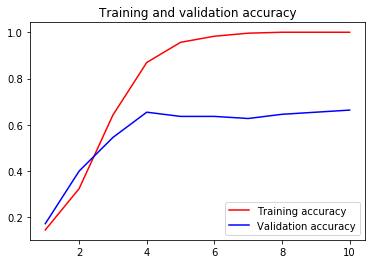

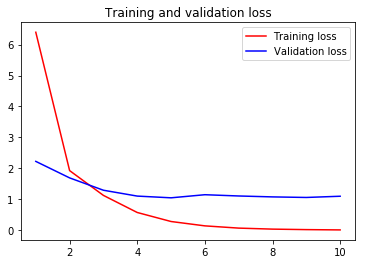

In [14]:
# TODO - Print a plot of loss and accuracy over epochs and learning rates
# TODO - Print a plot of loss and accuracy over epochs and learning rates
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(acc) + 1)

plt.title('Training and validation accuracy')
plt.plot(epochs, acc, 'red', label='Training accuracy')
plt.plot(epochs, val_acc, 'blue', label='Validation accuracy')
plt.legend()

plt.figure()
plt.title('Training and validation loss')
plt.plot(epochs, loss, 'red', label='Training loss')
plt.plot(epochs, val_loss, 'blue', label='Validation loss')

plt.legend()

plt.show()

In [15]:
# Save and Evaluate the SIMPLE model on the validation data
#print("SAVE SIMPLE MODEL")
#simple_model.save('models/simple_model.h5')
print(history.history.keys())
loss, acc = simple_model.evaluate(TEST_IMG, TEST_CLS, verbose=1)
print("Loss: ", loss, " Accuracy: ", acc)

dict_keys(['val_loss', 'val_acc', 'loss', 'acc'])
272/272 [==============================] - 1s 3ms/step
Loss:  1.1892122871735518  Accuracy:  0.6470588235294118


In [16]:
# # Append results to the end of a text file
# with open("results_simple_cnn.txt", 'a') as f:
#     f.write('{{ "accuracy":{}, "epochs":{}, "kernel":"{}", "num_filters":{}, "input_shape":"{}" }} \n'.format(
#         acc, EPOCHS, test_kernel, num_filters, input_shape))